In [3]:

import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
# from google.colab.patches import cv2_imshow
import re
from bs4 import BeautifulSoup #for reading xml file
import matplotlib.pyplot as plt
# from wordcloud import WordCloud, STOPWORDS  #for plotting wordcloud
from tqdm import tqdm

In [9]:
import cv2

## Creatign dataset for training

In [4]:

image_folder = '/Users/kimberlyllajarunaperalta/Documents/MLOps/data_medical/NLMCXR_png' #path to folder containing images
total_images = len(os.listdir(image_folder))
print('The number of images in data are: %i'%(total_images))

The number of images in data are: 7471


In [11]:
reports_folder = "/Users/kimberlyllajarunaperalta/Documents/MLOps/data_medical/ecgen-radiology"
total_reports = len(os.listdir(reports_folder))
print('The number of reports in the data are: %i'%(total_reports))

The number of reports in the data are: 3955


In [12]:
no_images = [] #stores the no. of images
for file in os.listdir(reports_folder):
  report_file = os.path.join(reports_folder,file)
  with open(report_file, 'r') as f:  #reading the xml data
    data = f.read()
  regex = r"parentImage id.*" #getting all the image names
  k  = re.findall(regex,data)
  temp = len(k)
  no_images.append(temp)

In [13]:
no_images = np.array(no_images)
print("The max no. of images found associated with a report: %i"%(no_images.max()))
print("The min no. of images found associated with a report: %i"%(no_images.min()))

The max no. of images found associated with a report: 5
The min no. of images found associated with a report: 0


In [14]:

# function for obtaining the different information part of the xml report file and preprocessing them and also adding the concernced image and report information to the dataframe
def decontracted(phrase): #https://stackoverflow.com/a/47091490
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


def get_info(xml_data,info): #https://regex101.com/
  """
  extracts the information data from the xml file and does text preprocessing on them
  here info can be 1 value in this list ["COMPARISON","INDICATION","FINDINGS","IMPRESSION"]
  """
  regex = r"\""  +info +r"\".*" 
  k = re.findall(regex,xml_data)[0] #finding info part of the report

  regex = r"\>.*\<"
  k = re.findall(regex,k)[0] #removing info string and /AbstractText>'

  regex = r"\d." 
  k = re.sub(regex,"",k) #removing all values like "1." and "2." etc

  regex = r"X+"
  k = re.sub(regex,"",k) #removing words like XXXX

  regex = r" \."
  k = re.sub(regex,"",k) #removing singular fullstop ie " ."

  regex = r"[^.a-zA-Z]" 
  k = re.sub(regex," ",k) #removing all special characters except for full stop

  regex = r"\."
  k = re.sub(regex," .",k) #adding space before fullstop
  k = decontracted(k) #perform decontraction
  k = k.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
  k = " ".join(k.split()) #removes unwanted spaces
  if k=="": #if the resulting sentence is an empty string return null value
    k = np.nan
  return k

def get_final(data):
  """
  given an xml data returns "COMPARISON","INDICATION","FINDINGS","IMPRESSION" part of the data
  """
  try: #assigning null values to the ones that don't have the concerned info
      comparison = get_info(data, "COMPARISON")
  except:
    comparison = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    indication = get_info(data, "INDICATION")
  except:
    indication = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    finding = get_info(data,"FINDINGS")
  except:
    finding = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    impression = get_info(data, "IMPRESSION")
  except:
    impression = np.nan;

  return comparison,indication,finding,impression

def get_df():
  """
  Given an xml data, it will extract the two image names and corresponding info text and returns a dataframe
  """
  im1 = [] #there are 2 images associated with a report
  im2 = []
  #stores info
  comparisons = []
  indications = []
  findings = []
  impressions = [] 
  report = [] #stores xml file name
  for file in tqdm(os.listdir(reports_folder)):
    report_file = os.path.join(reports_folder,file)
    with open(report_file, 'r') as f:  #reading the xml data
      data = f.read()
  
    regex = r"parentImage id.*" #getting all the image names
    k  = re.findall(regex,data)

    if len(k)==2: 
      regex = r"\".*\"" #getting the name
      image1 = re.findall(regex,k[0])[0]
      image2 = re.findall(regex,k[1])[0]

      image1 = re.sub(r"\"","",image1)
      image2 = re.sub(r"\"","",image2)

      image1 = image1.strip()+".png"
      image2 = image2.strip()+".png"
      im1.append(image1)
      im2.append(image2)

      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name

    
    elif len(k)<2:
      regex = r"\".*\"" #getting the name
      try: #if the exception is raised means no image file name was found
        image1 = re.findall(regex,k[0])[0]
        image1 = re.sub(r"\"","",image1) #removing "
        image2 = np.nan

        image1 = image1.strip()+".png"
      except:
        image1 = np.nan
        image2 = np.nan


      im1.append(image1)
      im2.append(image2)
      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name
    
    else: #if there are more than 2 images concerned with report
      comparison,indication,finding,impression = get_final(data)

      for i in range(len(k)-1):
        regex = r"\".*\"" #getting the name
        image1 = re.findall(regex,k[i])[0] #re.findall returns a list
        image2 = re.findall(regex,k[i+1])[0] 

        image1 = re.sub(r"\"","",image1) #removing "
        image2 = re.sub(r"\"","",image2) #removing "

        image1 = image1.strip()+".png"
        image2 = image2.strip()+".png"

        im1.append(image1)
        im2.append(image2)
        comparisons.append(comparison)
        indications.append(indication)
        findings.append(finding)
        impressions.append(impression)
        report.append(file) #xml file name
    
  df = pd.DataFrame({"image_1":im1,"image_2":im2,"comparison":comparisons,"indication":indications,"findings":findings,"impression":impressions,"xml file name":report})
  return df

In [63]:
%%time
df = get_df()

100%|██████████| 3955/3955 [00:00<00:00, 5221.65it/s]

CPU times: user 261 ms, sys: 93.6 ms, total: 355 ms
Wall time: 764 ms


In [64]:
# df.to_pickle("/content/drive/My Drive/Medical image Reporting/df.pkl")
# df = pd.read_pickle("/content/drive/My Drive/Medical image Reporting/df.pkl")
# df.shape

In [65]:
df.head()

,image_1,image_2,comparison,indication,findings,impression,xml file name
0,CXR162_IM-0401-1001.png,CXR162_IM-0401-2001.png,none .,.,heart size normal . lungs are clear . are norm...,normal chest,162.xml
1,CXR1390_IM-0249-1001.png,CXR1390_IM-0249-2001.png,none,slipped back on right side,the heart size and pulmonary vascularity appea...,no evidence of active disease .,1390.xml
2,CXR604_IM-2193-1001.png,CXR604_IM-2193-2001.png,.,bone marrow transplant evaluation . aml .,the heart size and pulmonary vascularity appea...,no evidence of active disease .,604.xml
3,CXR2699_IM-1167-1001.png,CXR2699_IM-1167-2001.png,none .,year old chest pain and,the heart is normal in size and contour . the ...,no acute cardiopulmonary disease .,2699.xml
4,CXR2841_IM-1253-2001.png,NaN,none .,year old mid to lower back pain since,the heart is normal in size and contour . the ...,no acute cardiopulmonary disease .,2841.xml


In [66]:
print("columns\t\t%missing values")
print('-'*30)
print(df.isnull().sum()*100/df.shape[0] )#percentage missing values

columns		%missing values
------------------------------
image_1           2.494603
image_2          13.192612
comparison       33.605181
indication        6.308467
findings         13.504438
impression        0.839530
xml file name     0.000000
dtype: float64


In [67]:
df.drop(df[(df['impression'].isnull())|(df['image_1'].isnull())].index,inplace=True)
df = df.reset_index(drop=True).copy()
print("%i datapoints were removed.\nFinal no. of datapoints: %i"%(4169-df.shape[0],df.shape[0]))
     


136 datapoints were removed.
Final no. of datapoints: 4033


In [68]:
%%time
df.loc[df.image_2.isnull(),'image_2'] = df[df.image_2.isnull()]['image_1'].values
im1_size = []
im2_size = []
for index,row in df.iterrows():
  im1_size.append( cv2.imread(os.path.join(image_folder,row.get('image_1'))).shape[:2])
  im2_size.append(cv2.imread(os.path.join(image_folder,row.get('image_2'))).shape[:2])

CPU times: user 16.6 s, sys: 1.43 s, total: 18 s
Wall time: 20.5 s


In [69]:

df['im1_height'] = [i[0] for i in im1_size]
df['im1_width'] = [i[1] for i in im1_size]
df['im2_height'] = [i[0] for i in im2_size]
df['im2_width'] = [i[1] for i in im2_size]

In [70]:
df.head()


,image_1,image_2,comparison,indication,findings,impression,xml file name,im1_height,im1_width,im2_height,im2_width
0,CXR162_IM-0401-1001.png,CXR162_IM-0401-2001.png,none .,.,heart size normal . lungs are clear . are norm...,normal chest,162.xml,420,512,624,512
1,CXR1390_IM-0249-1001.png,CXR1390_IM-0249-2001.png,none,slipped back on right side,the heart size and pulmonary vascularity appea...,no evidence of active disease .,1390.xml,512,512,512,512
2,CXR604_IM-2193-1001.png,CXR604_IM-2193-2001.png,.,bone marrow transplant evaluation . aml .,the heart size and pulmonary vascularity appea...,no evidence of active disease .,604.xml,512,512,615,512
3,CXR2699_IM-1167-1001.png,CXR2699_IM-1167-2001.png,none .,year old chest pain and,the heart is normal in size and contour . the ...,no acute cardiopulmonary disease .,2699.xml,443,512,497,512
4,CXR2841_IM-1253-2001.png,CXR2841_IM-1253-2001.png,none .,year old mid to lower back pain since,the heart is normal in size and contour . the ...,no acute cardiopulmonary disease .,2841.xml,557,512,557,512


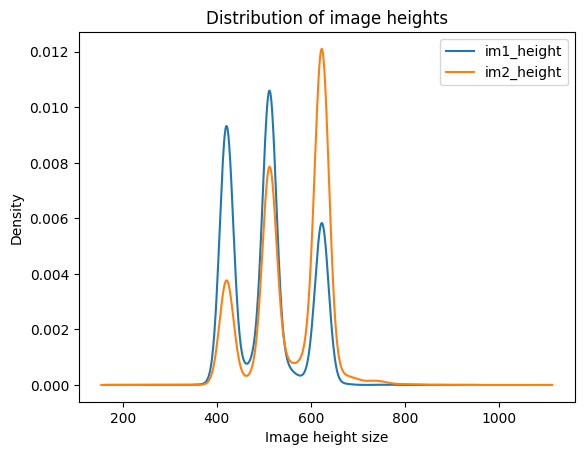



Value Counts of image_1 heights:

420    1130
512     926
624     674
511     234
618      87
Name: im1_height, dtype: int64

 ************************************************** 

Value Counts of image_2 heights:

624    1455
512     714
420     453
511     218
618      89
Name: im2_height, dtype: int64


In [71]:

ax = df[['im1_height','im2_height']].plot(kind='kde')
ax.set_title("Distribution of image heights")
ax.set_xlabel("Image height size")
plt.show()

print("\n\nValue Counts of image_1 heights:\n")
print(df.im1_height.value_counts()[:5])
print("\n","*"*50,"\n")
print("Value Counts of image_2 heights:\n")
print(df.im2_height.value_counts()[:5])
     

In [72]:
df.shape

(4033, 11)

In [73]:
def show_image_captions(df = df,image_folder = image_folder,sample = 3):
  """
  given the df, samples datapoints and prints the images and caption
  df: dataframe
  image_folder: folder which contains images
  """
  k = df.sample(sample)
  i=1
  for index,row in k.iterrows():
    image_1 = cv2.imread(os.path.join(image_folder,row.get('image_1')))
    image_2 = cv2.imread(os.path.join(image_folder,row.get('image_2')))

    plt.figure(figsize = (12,8)) #setting the figure size
    plt.subplot(121) #first x-ray
    plt.imshow(image_1,aspect='auto')

    plt.subplot(122) #2nd x-ray
    plt.imshow(image_2, aspect = 'auto')
    print("%i)\n"%(i))
    i+=1
    plt.show() #printing the image
    print("\n","Comparison: ",row.get('comparison'))
    print("\n","Indication: ",row.get('indication'))
    print("\n","Findings: ",row.get('findings'))
    print("\n","Impression: ",row.get('impression'),"\n\n","*"*150,"\n\n")

1)



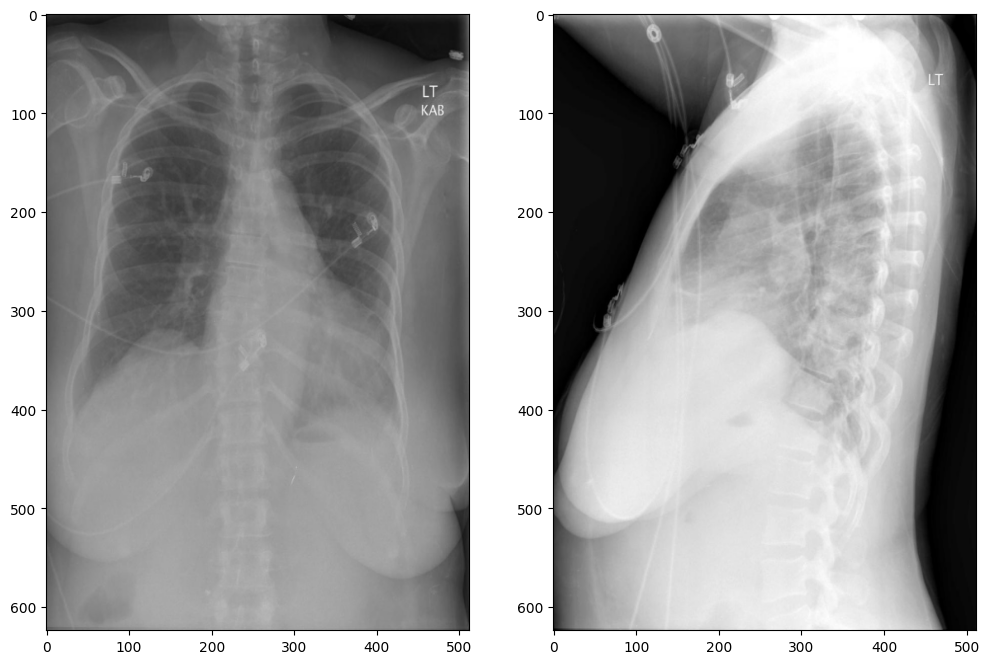


 Comparison:  abdomen and pelvis ct from

 Indication:  year old woman with and leukocytosis .

 Findings:  the heart is mildly enlarged . mediastinal contour and pulmonary vascularity are within normal limits . there are streaky left basilar airspace opacities compatible with atelectasis as seen on comparison abdomen and pelvis ct . there is a left upper lung granuloma . otherwise no focal consolidation large pleural effusion or pneumothorax . appear intact .

 Impression:  left basilar atelectasis . no acute cardiopulmonary abnormalities . 

 ****************************************************************************************************************************************************** 


2)



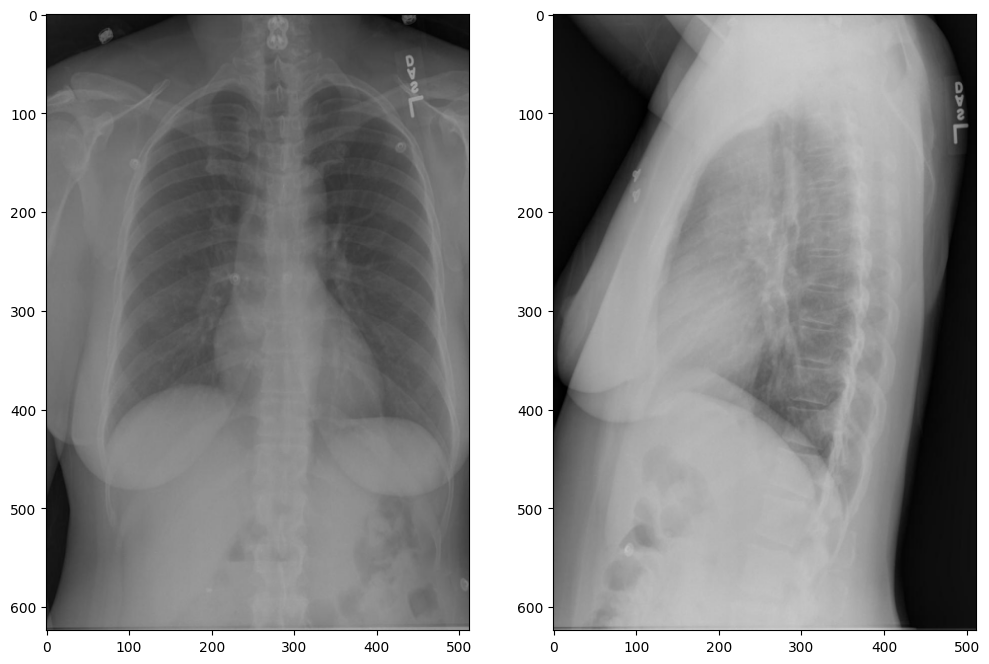


 Comparison:  nan

 Indication:  chest pain

 Findings:  heart size is normal . the lungs are clear . there are no focal air space consolidations . no pleural effusions or pneumothoraces . the hilar and mediastinal contours are unchanged . normal pulmonary vascularity . stable postsurgical changes of the lower cervical spine .

 Impression:  no acute abnormality . 

 ****************************************************************************************************************************************************** 


3)



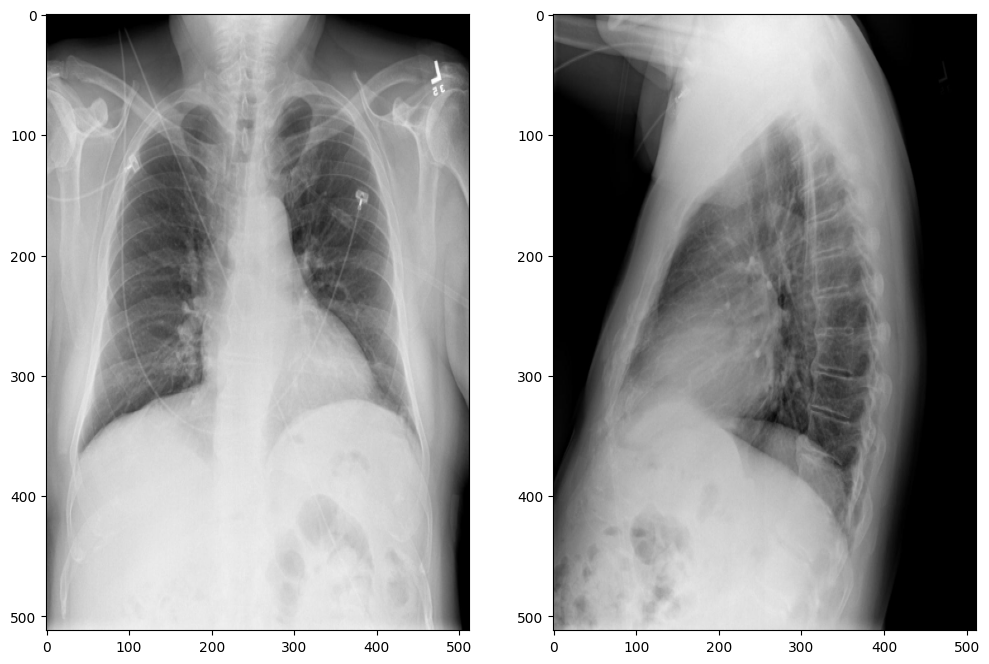


 Comparison:  nan

 Indication:  pain .

 Findings:  the lungs are clear . no pleural effusion is seen . the heart and mediastinum are normal . arthritic changes of the spine are present .

 Impression:  no active disease . 

 ****************************************************************************************************************************************************** 




In [74]:

#showing sample 3 datapoints
show_image_captions()
     

In [75]:
compression_opts = dict(method='zip',archive_name='xrays.csv') 
df.to_csv('xrays.zip', index=False, compression=compression_opts)

In [88]:
df_clean = df.copy()

In [89]:
df_clean.head()

,image_1,image_2,comparison,indication,findings,impression,xml file name,im1_height,im1_width,im2_height,im2_width
0,CXR162_IM-0401-1001.png,CXR162_IM-0401-2001.png,none .,.,heart size normal . lungs are clear . are norm...,normal chest,162.xml,420,512,624,512
1,CXR1390_IM-0249-1001.png,CXR1390_IM-0249-2001.png,none,slipped back on right side,the heart size and pulmonary vascularity appea...,no evidence of active disease .,1390.xml,512,512,512,512
2,CXR604_IM-2193-1001.png,CXR604_IM-2193-2001.png,.,bone marrow transplant evaluation . aml .,the heart size and pulmonary vascularity appea...,no evidence of active disease .,604.xml,512,512,615,512
3,CXR2699_IM-1167-1001.png,CXR2699_IM-1167-2001.png,none .,year old chest pain and,the heart is normal in size and contour . the ...,no acute cardiopulmonary disease .,2699.xml,443,512,497,512
4,CXR2841_IM-1253-2001.png,CXR2841_IM-1253-2001.png,none .,year old mid to lower back pain since,the heart is normal in size and contour . the ...,no acute cardiopulmonary disease .,2841.xml,557,512,557,512


## Figuring training now

### Putting data into right shape

In [92]:
df_clean[["findings"]]

,findings
0,heart size normal . lungs are clear . are norm...
1,the heart size and pulmonary vascularity appea...
2,the heart size and pulmonary vascularity appea...
3,the heart is normal in size and contour . the ...
4,the heart is normal in size and contour . the ...
...,...
4028,the lungs are clear . there is no pleural effu...
4029,the lungs are clear . there is no pleural effu...
4030,there are scattered calcified granulomas . no ...
4031,NaN


In [93]:
col = ['image_1','image_2','findings','impression','xml file name']
df_clean = df_clean[col].copy()
#path
df_clean['image_1'] = df_clean['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df_clean['image_2'] = df_clean['image_2'].apply(lambda row: os.path.join(image_folder,row))

df_clean['findings'] = ' ' + df_clean.findings + ' '   #kim adding this
df_clean['impression_final'] = ' ' + df_clean.impression + ' '
df_clean['impression_ip'] = ' ' + df_clean.impression
df_clean['impression_op'] = df_clean.impression + ' ' 
print(df_clean.shape)
df_clean.head(10)

(4033, 8)


,image_1,image_2,findings,impression,xml file name,impression_final,impression_ip,impression_op
0,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...,normal chest,162.xml,normal chest,normal chest,normal chest
1,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,the heart size and pulmonary vascularity appe...,no evidence of active disease .,1390.xml,no evidence of active disease .,no evidence of active disease .,no evidence of active disease .
2,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,the heart size and pulmonary vascularity appe...,no evidence of active disease .,604.xml,no evidence of active disease .,no evidence of active disease .,no evidence of active disease .
3,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,the heart is normal in size and contour . the...,no acute cardiopulmonary disease .,2699.xml,no acute cardiopulmonary disease .,no acute cardiopulmonary disease .,no acute cardiopulmonary disease .
4,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,the heart is normal in size and contour . the...,no acute cardiopulmonary disease .,2841.xml,no acute cardiopulmonary disease .,no acute cardiopulmonary disease .,no acute cardiopulmonary disease .
5,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,the lungs are clear . the cardiomediastinal s...,negative chest,3587.xml,negative chest,negative chest,negative chest
6,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,the lungs are clear bilaterally . specificall...,no acute cardiopulmonary abnormality .,2855.xml,no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality .
7,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...,normal chest,3593.xml,normal chest,normal chest,normal chest
8,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart is mildly heart enlarged . mediastinal ...,findings consistent with mild congestive heart...,88.xml,findings consistent with mild congestive hear...,findings consistent with mild congestive hear...,findings consistent with mild congestive heart...
9,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,NaN,no focal lung consolidation . no pneumothorax ...,610.xml,no focal lung consolidation . no pneumothorax...,no focal lung consolidation . no pneumothorax...,no focal lung consolidation . no pneumothorax ...


In [97]:
df_clean['information'] = df_clean['findings'].str.cat(df_clean['impression'], sep=' ')

In [113]:
df_clean[["information"]]

,information
0,heart size normal . lungs are clear . are nor...
1,the heart size and pulmonary vascularity appe...
2,the heart size and pulmonary vascularity appe...
3,the heart is normal in size and contour . the...
4,the heart is normal in size and contour . the...
...,...
4028,the lungs are clear . there is no pleural eff...
4029,the lungs are clear . there is no pleural eff...
4030,there are scattered calcified granulomas . no...
4031,NaN


In [85]:
# col = ['image_1','image_2','impression','xml file name']
# df = df[col].copy()
# #path
# df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
# df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

# df['findings'] = ' ' + df.findings + ' '   #kim adding this
# df['impression_final'] = ' ' + df.impression + ' '
# df['impression_ip'] = ' ' + df.impression
# df['impression_op'] = df.impression + ' ' 
# print(df.shape)
# df.head(10)

In [114]:
df_clean['impression'].value_counts()


no acute cardiopulmonary abnormality .                                                                                                                                  383
no acute cardiopulmonary findings .                                                                                                                                     172
no acute cardiopulmonary disease .                                                                                                                                      147
no acute cardiopulmonary abnormalities .                                                                                                                                141
no active disease .                                                                                                                                                     137
                                                                                                                                            

In [115]:
df_clean['information'].value_counts()


 the heart and lungs have in the interval . both lungs are clear and expanded . heart and mediastinum normal .  no active disease .                                                                                                                                                                                                                        55
 the heart is normal in size . the mediastinum is unremarkable . the lungs are clear .  no acute disease .                                                                                                                                                                                                                                                 52
 heart size normal . lungs are clear . are normal . no pneumonia effusions edema pneumothorax adenopathy nodules or masses .  normal chest                                                                                                                                                                  

In [116]:
df_clean.drop_duplicates(subset = ['xml file name'], inplace = True)


In [118]:

#adding a new column impression counts which tells the total value counts of impression of that datapoint 
k = df_clean['information'].value_counts()
df_clean = df_clean.merge(k,
         left_on = 'information',
         right_index=True) #join left impression value with right index

df_clean.columns

Index(['information', 'image_1', 'image_2', 'findings', 'impression',
       'xml file name', 'impression_final', 'impression_ip', 'impression_op',
       'information_x', 'information_y'],
      dtype='object')

In [119]:
# df.columns = ['impression', 'image_1', 'image_2', 'impression_x', 'xml file name','impression_final',
#        'impression_ip', 'impression_op', 'impression_counts'] #changin column names
# del df['impression_x'] #deleting impression_x column
# df.head()

In [120]:
df_clean.tail(10)

,information,image_1,image_2,findings,impression,xml file name,impression_final,impression_ip,impression_op,information_x,information_y
4007,the trachea is midline . the cardiomediastina...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,the trachea is midline . the cardiomediastina...,no acute cardiopulmonary findings .,2131.xml,no acute cardiopulmonary findings .,no acute cardiopulmonary findings .,no acute cardiopulmonary findings .,the trachea is midline . the cardiomediastina...,1
4011,chronic bilateral emphysematous changes . the...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,chronic bilateral emphysematous changes . the...,no acute cardiopulmonary abnormalities .,812.xml,no acute cardiopulmonary abnormalities .,no acute cardiopulmonary abnormalities .,no acute cardiopulmonary abnormalities .,chronic bilateral emphysematous changes . the...,1
4013,the cardiac silhouette is borderline enlarged...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,the cardiac silhouette is borderline enlarged...,borderline cardiomegaly . no acute findings .,806.xml,borderline cardiomegaly . no acute findings .,borderline cardiomegaly . no acute findings .,borderline cardiomegaly . no acute findings .,the cardiac silhouette is borderline enlarged...,1
4017,there is a right ij central venous catheter w...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,there is a right ij central venous catheter w...,right pleural effusion .,153.xml,right pleural effusion .,right pleural effusion .,right pleural effusion .,there is a right ij central venous catheter w...,1
4018,the examination consists of frontal and later...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,the examination consists of frontal and later...,no acute cardiopulmonary abnormality identified .,2870.xml,no acute cardiopulmonary abnormality identifi...,no acute cardiopulmonary abnormality identifi...,no acute cardiopulmonary abnormality identifie...,the examination consists of frontal and later...,1
4022,the lungs are clear . heart and pulmonary app...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,the lungs are clear . heart and pulmonary app...,no acute cardiopulmonary disease,147.xml,no acute cardiopulmonary disease,no acute cardiopulmonary disease,no acute cardiopulmonary disease,the lungs are clear . heart and pulmonary app...,1
4023,minimal right to left cardiomediastinal shift...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,minimal right to left cardiomediastinal shift...,moderate sized right pneumothorax . there is m...,91.xml,moderate sized right pneumothorax . there is ...,moderate sized right pneumothorax . there is ...,moderate sized right pneumothorax . there is m...,minimal right to left cardiomediastinal shift...,1
4024,stable cardiomediastinal silhouette . pulmona...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,stable cardiomediastinal silhouette . pulmona...,no acute cardiopulmonary abnormality .,609.xml,no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality .,stable cardiomediastinal silhouette . pulmona...,1
4026,heart size normal . tortuous aorta . sequela ...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . tortuous aorta . sequela ...,no acute cardiopulmonary finding .,2858.xml,no acute cardiopulmonary finding .,no acute cardiopulmonary finding .,no acute cardiopulmonary finding .,heart size normal . tortuous aorta . sequela ...,1
4030,there are scattered calcified granulomas . no...,/Users/kimberlyllajarunaperalta/Do

In [125]:
df_final = df_clean.copy()
df_final = df_final[['image_1', 'image_2','information_x']] #choose only these columns
# del df['impression_x'] #deleting impression_x column
df_final.head()

,image_1,image_2,information_x
0,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
7,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
195,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
299,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
304,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...


In [126]:
df_final.shape

(3331, 3)

In [127]:
df_final.tail()

,image_1,image_2,information_x
4022,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,the lungs are clear . heart and pulmonary app...
4023,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,minimal right to left cardiomediastinal shift...
4024,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,stable cardiomediastinal silhouette . pulmona...
4026,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . tortuous aorta . sequela ...
4030,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,there are scattered calcified granulomas . no...


Trying to use only one image

In [140]:
df_final_1 = df_clean.copy()
df_final_1 = df_final[['image_1','information_x']] #choose only these columns
# del df['impression_x'] #deleting impression_x column
df_final_1.head(10)

,image_1,information_x
0,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
7,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
195,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
299,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
304,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
335,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
359,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
487,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
520,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...
587,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...


In [133]:
df_final_1.to_csv('df_final_1.csv', index=False)

In [138]:
df_final_1.to_json('df_final_1.json')

### Creating dataset

In [150]:
# pip install tensorflow


In [151]:
pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [152]:

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
# import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [155]:
train =  df_final

In [159]:
train['impression_final'] = ' ' + train.information_x + ' '


In [161]:
train.head()

,image_1,image_2,information_x,impression_final
0,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...,heart size normal . lungs are clear . are no...
7,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...,heart size normal . lungs are clear . are no...
195,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...,heart size normal . lungs are clear . are no...
299,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...,heart size normal . lungs are clear . are no...
304,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...,heart size normal . lungs are clear . are no...


In [ ]:
# col = ['image_1','image_2','impression','xml file name']
# df = df[col].copy()
# #path
# df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
# df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

# df['impression_final'] = ' ' + df.impression + ' '
# df['impression_ip'] = ' ' + df.impression
# df['impression_op'] = df.impression + ' ' 
# print(df.shape)
# df.head(2)

In [173]:

#adding a new column impression counts which tells the total value counts of impression of that datapoint 
k = train['impression_final'].value_counts()
train = train.merge(k,
         left_on = 'impression_final',
         right_index=True) #join left impression value with right index

train.columns

Index(['impression_final', 'impression_final_x', 'image_1', 'image_2',
       'information_x', 'impression_final_y'],
      dtype='object')

In [174]:
train.head()

,impression_final,impression_final_x,image_1,image_2,information_x,impression_final_y
0,heart size normal . lungs are clear . are no...,heart size normal . lungs are clear . are no...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...,34
7,heart size normal . lungs are clear . are no...,heart size normal . lungs are clear . are no...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...,34
195,heart size normal . lungs are clear . are no...,heart size normal . lungs are clear . are no...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...,34
299,heart size normal . lungs are clear . are no...,heart size normal . lungs are clear . are no...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...,34
304,heart size normal . lungs are clear . are no...,heart size normal . lungs are clear . are no...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . lungs are clear . are nor...,34


In [175]:
# del train["impression_final_y"]
# train.head()

In [179]:
train = train.rename(columns={"impression_final_y": "count"})

In [180]:
train.tail()

,impression_final,impression_final_x,image_1,image_2,information_x,count
4022,the lungs are clear . heart and pulmonary ap...,the lungs are clear . heart and pulmonary ap...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,the lungs are clear . heart and pulmonary app...,1
4023,minimal right to left cardiomediastinal shif...,minimal right to left cardiomediastinal shif...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,minimal right to left cardiomediastinal shift...,1
4024,stable cardiomediastinal silhouette . pulmon...,stable cardiomediastinal silhouette . pulmon...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,stable cardiomediastinal silhouette . pulmona...,1
4026,heart size normal . tortuous aorta . sequela...,heart size normal . tortuous aorta . sequela...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,heart size normal . tortuous aorta . sequela ...,1
4030,there are scattered calcified granulomas . n...,there are scattered calcified granulomas . n...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,/Users/kimberlyllajarunaperalta/Documents/MLOp...,there are scattered calcified granulomas . no...,1


### Trying to split it

In [182]:
from sklearn.model_selection import train_test_split
other1 = train[train['count']>5] #selecting those datapoints which have impression valuecounts >5
other2 = train[train['count']<=5] #selecting those datapoints which have impression valuecounts <=5
train,test = train_test_split(other1,stratify = other1['impression_final'].values,test_size = 0.1,random_state = 420)
test_other2_sample = other2.sample(int(0.2*other2.shape[0]),random_state = 420) #getting some datapoints from other2 data for test data
other2 = other2.drop(test_other2_sample.index,axis=0)
#here i will be choosing 0.5 as the test size as to create a reasonable size of test data
test = test.append(test_other2_sample)
test = test.reset_index(drop=True)

train = train.append(other2) 
train = train.reset_index(drop=True)
train.shape[0],test.shape[0]

(2720, 611)

In [183]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '') #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index[''] #tokened value of 
end_index = tokenizer.word_index[''] #tokened value of 

In [185]:
max_pad = int(np.percentile(caption_len,80))


In [186]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and impression
    """
    self.image1 = df.image_1
    self.image2 = df.image_2
    self.caption = df.impression_ip #inp
    self.caption1 = df.impression_op  #output
    self.input_size = input_size #tuple ex: (512,512)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    # #image augmentation
    # #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    # self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    # self.aug2 = iaa.Flipud(1) #flip images vertically


  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)
    if image1.any()==None:
      print("%i , %s image sent null value"%(i,self.image1[i]))
    if image2.any()==None:
      print("%i , %s image sent null value"%(i,self.image2[i]))


    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
    caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
    caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.333:
              image1 = self.aug1.augment_image(image1)
              image2 = self.aug1.augment_image(image2)
          elif a<0.667:
              image1 = self.aug2.augment_image(image1)
              image2 = self.aug2.augment_image(image2)
          else: #applying no augmentation
            pass;

    
    return image1,image2,caption,caption1

    
  def __len__(self):
    return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]],batch[3]]) #here [image1,image2, caption(without )],caption(without ) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [ ]:
# path to the folder containing the images
root = "/Users/kimberlyllajarunaperalta/Documents/MLOps/data_medical/NLMCXR_png"

# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

In [134]:
from datasets import load_dataset


In [139]:
dataset = load_dataset("xrays", data_dir="/Users/kimberlyllajarunaperalta/Documents/MLOps/AC215_BiteSize/notebooks/model-training/datasets/xrays")
dataset[0]["text"]

FileNotFoundError: Couldn't find a dataset script at /Users/kimberlyllajarunaperalta/Documents/MLOps/AC215_BiteSize/notebooks/model-training/xrays/xrays.py or any data file in the same directory. Couldn't find 'xrays' on the Hugging Face Hub either: FileNotFoundError: Dataset 'xrays' doesn't exist on the Hub. If the repo is private or gated, make sure to log in with `huggingface-cli login`.